# Comparative Evaluation of Fine-Tuned LLMs for Constraint-Aware Recipe Generation

**Course:** YZV303E Deep Learning

**Models Evaluated:**
- Mistral 7B with QLoRA fine-tuning
- Phi-3 Mini with full parameter fine-tuning

**Evaluation Metrics:**
1. Ingredient Adherence (Recall)
2. Hallucination Score (Constraint Violation Detection)
3. Contextual Accuracy (Meal Type Appropriateness)

## 1. Environment Setup

In [1]:
# Install required dependencies
!pip install -q transformers accelerate bitsandbytes peft
!pip install -q matplotlib pandas

# Mount Google Drive to access the Phi-3 model checkpoint
from google.colab import drive
drive.mount('/content/drive')

print("Environment setup complete.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Environment setup complete.


## 2. Test Scenario Definitions

This section defines 100 test scenarios across four meal categories. Each scenario specifies:
- Input ingredients
- Meal context (breakfast, lunch, dinner, snack)
- Whether the input contains protein or dairy (used for hallucination detection)

54 scenarios contain no protein or dairy, making them critical tests for constraint adherence.

In [2]:
TEST_SCENARIOS = [
    # BREAKFAST (1-25)
    {"id": 1, "context": "breakfast", "ingredients": ["eggs", "bread", "butter"],
     "has_protein": True, "has_dairy": True, "note": "Classic breakfast"},

    {"id": 2, "context": "breakfast", "ingredients": ["oats", "banana", "honey"],
     "has_protein": False, "has_dairy": False, "note": "Vegan - should not add milk"},

    {"id": 3, "context": "breakfast", "ingredients": ["flour", "eggs", "milk", "sugar"],
     "has_protein": True, "has_dairy": True, "note": "Pancake ingredients"},

    {"id": 4, "context": "breakfast", "ingredients": ["avocado", "bread", "lemon"],
     "has_protein": False, "has_dairy": False, "note": "Vegan - should not add eggs"},

    {"id": 5, "context": "breakfast", "ingredients": ["yogurt", "berries", "granola"],
     "has_protein": False, "has_dairy": True, "note": "Parfait"},

    {"id": 6, "context": "breakfast", "ingredients": ["potato", "onion", "bell pepper"],
     "has_protein": False, "has_dairy": False, "note": "Vegan hash browns"},

    {"id": 7, "context": "breakfast", "ingredients": ["bacon", "eggs", "cheese", "tortilla"],
     "has_protein": True, "has_dairy": True, "note": "Breakfast burrito"},

    {"id": 8, "context": "breakfast", "ingredients": ["apple", "cinnamon", "oats", "maple syrup"],
     "has_protein": False, "has_dairy": False, "note": "Vegan baked oatmeal"},

    {"id": 9, "context": "breakfast", "ingredients": ["spinach", "tomato", "mushroom", "eggs"],
     "has_protein": True, "has_dairy": False, "note": "Veggie omelet"},

    {"id": 10, "context": "breakfast", "ingredients": ["banana", "peanut butter", "bread"],
     "has_protein": False, "has_dairy": False, "note": "Vegan toast"},

    {"id": 11, "context": "breakfast", "ingredients": ["cream cheese", "bagel", "smoked salmon"],
     "has_protein": True, "has_dairy": True, "note": "Lox bagel"},

    {"id": 12, "context": "breakfast", "ingredients": ["tofu", "turmeric", "onion", "bell pepper"],
     "has_protein": False, "has_dairy": False, "note": "Vegan scramble"},

    {"id": 13, "context": "breakfast", "ingredients": ["cornmeal", "water", "salt"],
     "has_protein": False, "has_dairy": False, "note": "Vegan grits"},

    {"id": 14, "context": "breakfast", "ingredients": ["eggs", "ham", "cheese", "english muffin"],
     "has_protein": True, "has_dairy": True, "note": "Eggs Benedict base"},

    {"id": 15, "context": "breakfast", "ingredients": ["chia seeds", "almond milk", "mango"],
     "has_protein": False, "has_dairy": False, "note": "Vegan chia pudding"},

    {"id": 16, "context": "breakfast", "ingredients": ["sweet potato", "black beans", "salsa"],
     "has_protein": False, "has_dairy": False, "note": "Vegan breakfast bowl"},

    {"id": 17, "context": "breakfast", "ingredients": ["cottage cheese", "peach", "honey"],
     "has_protein": False, "has_dairy": True, "note": "Cottage cheese bowl"},

    {"id": 18, "context": "breakfast", "ingredients": ["rice", "egg", "soy sauce", "green onion"],
     "has_protein": True, "has_dairy": False, "note": "Breakfast fried rice"},

    {"id": 19, "context": "breakfast", "ingredients": ["coconut milk", "rice", "mango"],
     "has_protein": False, "has_dairy": False, "note": "Vegan coconut rice"},

    {"id": 20, "context": "breakfast", "ingredients": ["sausage", "eggs", "biscuit", "gravy"],
     "has_protein": True, "has_dairy": True, "note": "Southern breakfast"},

    {"id": 21, "context": "breakfast", "ingredients": ["strawberry", "banana", "spinach", "orange juice"],
     "has_protein": False, "has_dairy": False, "note": "Vegan smoothie"},

    {"id": 22, "context": "breakfast", "ingredients": ["bread", "cinnamon", "eggs", "milk", "vanilla"],
     "has_protein": True, "has_dairy": True, "note": "French toast"},

    {"id": 23, "context": "breakfast", "ingredients": ["zucchini", "carrot", "flour", "baking powder"],
     "has_protein": False, "has_dairy": False, "note": "Vegan veggie muffins"},

    {"id": 24, "context": "breakfast", "ingredients": ["prosciutto", "melon", "mint"],
     "has_protein": True, "has_dairy": False, "note": "Italian breakfast"},

    {"id": 25, "context": "breakfast", "ingredients": ["tempeh", "maple syrup", "pepper"],
     "has_protein": False, "has_dairy": False, "note": "Vegan tempeh bacon"},

    # LUNCH (26-50)
    {"id": 26, "context": "lunch", "ingredients": ["bread", "turkey", "lettuce", "tomato", "mayonnaise"],
     "has_protein": True, "has_dairy": False, "note": "Turkey sandwich"},

    {"id": 27, "context": "lunch", "ingredients": ["lettuce", "cucumber", "tomato", "olive oil", "lemon"],
     "has_protein": False, "has_dairy": False, "note": "Vegan salad"},

    {"id": 28, "context": "lunch", "ingredients": ["tuna", "celery", "mayonnaise", "bread"],
     "has_protein": True, "has_dairy": False, "note": "Tuna sandwich"},

    {"id": 29, "context": "lunch", "ingredients": ["rice", "beans", "salsa", "avocado"],
     "has_protein": False, "has_dairy": False, "note": "Vegan burrito bowl"},

    {"id": 30, "context": "lunch", "ingredients": ["pasta", "olive oil", "garlic", "parmesan"],
     "has_protein": False, "has_dairy": True, "note": "Aglio e olio"},

    {"id": 31, "context": "lunch", "ingredients": ["chickpeas", "tahini", "lemon", "garlic", "pita"],
     "has_protein": False, "has_dairy": False, "note": "Vegan hummus"},

    {"id": 32, "context": "lunch", "ingredients": ["quinoa", "black beans", "corn", "lime"],
     "has_protein": False, "has_dairy": False, "note": "Vegan grain bowl"},

    {"id": 33, "context": "lunch", "ingredients": ["chicken", "romaine", "parmesan", "croutons"],
     "has_protein": True, "has_dairy": True, "note": "Caesar salad"},

    {"id": 34, "context": "lunch", "ingredients": ["lentils", "onion", "carrot", "vegetable broth"],
     "has_protein": False, "has_dairy": False, "note": "Vegan lentil soup"},

    {"id": 35, "context": "lunch", "ingredients": ["falafel", "cucumber", "tomato", "tahini", "pita"],
     "has_protein": False, "has_dairy": False, "note": "Vegan falafel wrap"},

    {"id": 36, "context": "lunch", "ingredients": ["egg", "mayonnaise", "mustard", "celery"],
     "has_protein": True, "has_dairy": False, "note": "Egg salad"},

    {"id": 37, "context": "lunch", "ingredients": ["tomato", "mozzarella", "basil", "balsamic"],
     "has_protein": False, "has_dairy": True, "note": "Caprese salad"},

    {"id": 38, "context": "lunch", "ingredients": ["edamame", "cucumber", "rice", "nori", "soy sauce"],
     "has_protein": False, "has_dairy": False, "note": "Vegan sushi bowl"},

    {"id": 39, "context": "lunch", "ingredients": ["grilled chicken", "pesto", "sun-dried tomato", "ciabatta"],
     "has_protein": True, "has_dairy": True, "note": "Italian sandwich"},

    {"id": 40, "context": "lunch", "ingredients": ["sweet potato", "kale", "tahini", "chickpeas"],
     "has_protein": False, "has_dairy": False, "note": "Vegan buddha bowl"},

    {"id": 41, "context": "lunch", "ingredients": ["ham", "swiss cheese", "bread", "mustard"],
     "has_protein": True, "has_dairy": True, "note": "Ham and cheese"},

    {"id": 42, "context": "lunch", "ingredients": ["white beans", "rosemary", "garlic", "olive oil", "bread"],
     "has_protein": False, "has_dairy": False, "note": "Vegan bean bruschetta"},

    {"id": 43, "context": "lunch", "ingredients": ["shrimp", "avocado", "lime", "tortilla"],
     "has_protein": True, "has_dairy": False, "note": "Shrimp tacos"},

    {"id": 44, "context": "lunch", "ingredients": ["carrot", "cabbage", "peanut", "rice noodles", "lime"],
     "has_protein": False, "has_dairy": False, "note": "Vegan Thai salad"},

    {"id": 45, "context": "lunch", "ingredients": ["beet", "arugula", "walnut", "goat cheese"],
     "has_protein": False, "has_dairy": True, "note": "Beet salad"},

    {"id": 46, "context": "lunch", "ingredients": ["mushroom", "spinach", "garlic", "vegetable broth"],
     "has_protein": False, "has_dairy": False, "note": "Vegan mushroom soup"},

    {"id": 47, "context": "lunch", "ingredients": ["pulled pork", "coleslaw", "bun", "bbq sauce"],
     "has_protein": True, "has_dairy": False, "note": "Pulled pork sandwich"},

    {"id": 48, "context": "lunch", "ingredients": ["cucumber", "dill", "rice vinegar", "sesame"],
     "has_protein": False, "has_dairy": False, "note": "Vegan cucumber salad"},

    {"id": 49, "context": "lunch", "ingredients": ["crab", "old bay", "mayonnaise", "bun"],
     "has_protein": True, "has_dairy": False, "note": "Crab cake sandwich"},

    {"id": 50, "context": "lunch", "ingredients": ["cauliflower", "buffalo sauce", "celery", "lettuce"],
     "has_protein": False, "has_dairy": False, "note": "Vegan buffalo wrap"},

    # DINNER (51-80)
    {"id": 51, "context": "dinner", "ingredients": ["chicken", "rice", "broccoli", "soy sauce"],
     "has_protein": True, "has_dairy": False, "note": "Stir fry"},

    {"id": 52, "context": "dinner", "ingredients": ["pasta", "tomato", "basil", "garlic"],
     "has_protein": False, "has_dairy": False, "note": "Vegan pasta - critical test"},

    {"id": 53, "context": "dinner", "ingredients": ["salmon", "lemon", "dill", "asparagus"],
     "has_protein": True, "has_dairy": False, "note": "Fish dinner"},

    {"id": 54, "context": "dinner", "ingredients": ["beef", "potato", "carrot", "onion"],
     "has_protein": True, "has_dairy": False, "note": "Beef stew"},

    {"id": 55, "context": "dinner", "ingredients": ["tofu", "mushroom", "bok choy", "ginger", "garlic"],
     "has_protein": False, "has_dairy": False, "note": "Vegan Asian dinner"},

    {"id": 56, "context": "dinner", "ingredients": ["shrimp", "garlic", "butter", "parsley", "pasta"],
     "has_protein": True, "has_dairy": True, "note": "Shrimp scampi"},

    {"id": 57, "context": "dinner", "ingredients": ["eggplant", "tomato", "mozzarella", "basil"],
     "has_protein": False, "has_dairy": True, "note": "Eggplant parmesan"},

    {"id": 58, "context": "dinner", "ingredients": ["lentils", "carrot", "celery", "tomato", "cumin"],
     "has_protein": False, "has_dairy": False, "note": "Vegan lentil stew"},

    {"id": 59, "context": "dinner", "ingredients": ["pork", "apple", "sage", "potato"],
     "has_protein": True, "has_dairy": False, "note": "Pork chop"},

    {"id": 60, "context": "dinner", "ingredients": ["chickpeas", "spinach", "coconut milk", "curry powder"],
     "has_protein": False, "has_dairy": False, "note": "Vegan chickpea curry"},

    {"id": 61, "context": "dinner", "ingredients": ["lamb", "rosemary", "garlic", "potato"],
     "has_protein": True, "has_dairy": False, "note": "Roast lamb"},

    {"id": 62, "context": "dinner", "ingredients": ["black beans", "rice", "plantain", "lime"],
     "has_protein": False, "has_dairy": False, "note": "Vegan Cuban bowl"},

    {"id": 63, "context": "dinner", "ingredients": ["duck", "orange", "honey", "thyme"],
     "has_protein": True, "has_dairy": False, "note": "Duck a l'orange"},

    {"id": 64, "context": "dinner", "ingredients": ["cauliflower", "tahini", "pomegranate", "parsley"],
     "has_protein": False, "has_dairy": False, "note": "Vegan roasted cauliflower"},

    {"id": 65, "context": "dinner", "ingredients": ["cod", "tomato", "olive", "caper", "oregano"],
     "has_protein": True, "has_dairy": False, "note": "Mediterranean fish"},

    {"id": 66, "context": "dinner", "ingredients": ["mushroom", "risotto rice", "vegetable broth", "white wine"],
     "has_protein": False, "has_dairy": False, "note": "Vegan mushroom risotto"},

    {"id": 67, "context": "dinner", "ingredients": ["chicken thigh", "olive", "lemon", "artichoke"],
     "has_protein": True, "has_dairy": False, "note": "Greek chicken"},

    {"id": 68, "context": "dinner", "ingredients": ["jackfruit", "bbq sauce", "coleslaw", "bun"],
     "has_protein": False, "has_dairy": False, "note": "Vegan pulled jackfruit"},

    {"id": 69, "context": "dinner", "ingredients": ["steak", "mushroom", "red wine", "thyme"],
     "has_protein": True, "has_dairy": False, "note": "Steak with mushroom sauce"},

    {"id": 70, "context": "dinner", "ingredients": ["spaghetti", "olive oil", "chili flake", "garlic"],
     "has_protein": False, "has_dairy": False, "note": "Vegan aglio olio"},

    {"id": 71, "context": "dinner", "ingredients": ["turkey", "cranberry", "stuffing", "gravy"],
     "has_protein": True, "has_dairy": False, "note": "Turkey dinner"},

    {"id": 72, "context": "dinner", "ingredients": ["tempeh", "peanut sauce", "broccoli", "rice"],
     "has_protein": False, "has_dairy": False, "note": "Vegan tempeh bowl"},

    {"id": 73, "context": "dinner", "ingredients": ["mussels", "white wine", "garlic", "parsley"],
     "has_protein": True, "has_dairy": False, "note": "Steamed mussels"},

    {"id": 74, "context": "dinner", "ingredients": ["butternut squash", "sage", "pasta", "olive oil"],
     "has_protein": False, "has_dairy": False, "note": "Vegan squash pasta"},

    {"id": 75, "context": "dinner", "ingredients": ["pork belly", "soy sauce", "ginger", "star anise"],
     "has_protein": True, "has_dairy": False, "note": "Braised pork belly"},

    {"id": 76, "context": "dinner", "ingredients": ["portobello", "balsamic", "garlic", "spinach"],
     "has_protein": False, "has_dairy": False, "note": "Vegan portobello steak"},

    {"id": 77, "context": "dinner", "ingredients": ["chicken breast", "cream", "parmesan", "fettuccine"],
     "has_protein": True, "has_dairy": True, "note": "Chicken alfredo"},

    {"id": 78, "context": "dinner", "ingredients": ["zucchini", "tomato", "bell pepper", "onion", "herb"],
     "has_protein": False, "has_dairy": False, "note": "Vegan ratatouille"},

    {"id": 79, "context": "dinner", "ingredients": ["lobster", "butter", "lemon", "chive"],
     "has_protein": True, "has_dairy": True, "note": "Lobster tail"},

    {"id": 80, "context": "dinner", "ingredients": ["seitan", "bell pepper", "onion", "fajita seasoning"],
     "has_protein": False, "has_dairy": False, "note": "Vegan fajitas"},

    # SNACK (81-100)
    {"id": 81, "context": "snack", "ingredients": ["apple", "peanut butter"],
     "has_protein": False, "has_dairy": False, "note": "Vegan simple snack"},

    {"id": 82, "context": "snack", "ingredients": ["tortilla chips", "cheese", "jalapeno"],
     "has_protein": False, "has_dairy": True, "note": "Nachos"},

    {"id": 83, "context": "snack", "ingredients": ["cucumber", "hummus"],
     "has_protein": False, "has_dairy": False, "note": "Vegan snack"},

    {"id": 84, "context": "snack", "ingredients": ["banana", "chocolate", "almond"],
     "has_protein": False, "has_dairy": False, "note": "Vegan sweet snack"},

    {"id": 85, "context": "snack", "ingredients": ["cream cheese", "celery", "carrot"],
     "has_protein": False, "has_dairy": True, "note": "Veggie sticks"},

    {"id": 86, "context": "snack", "ingredients": ["dates", "walnut", "coconut"],
     "has_protein": False, "has_dairy": False, "note": "Vegan energy balls"},

    {"id": 87, "context": "snack", "ingredients": ["popcorn", "nutritional yeast", "olive oil"],
     "has_protein": False, "has_dairy": False, "note": "Vegan cheesy popcorn"},

    {"id": 88, "context": "snack", "ingredients": ["pretzels", "mustard"],
     "has_protein": False, "has_dairy": False, "note": "Vegan simple snack"},

    {"id": 89, "context": "snack", "ingredients": ["mozzarella", "tomato", "basil"],
     "has_protein": False, "has_dairy": True, "note": "Caprese bites"},

    {"id": 90, "context": "snack", "ingredients": ["edamame", "sea salt"],
     "has_protein": False, "has_dairy": False, "note": "Vegan protein snack"},

    {"id": 91, "context": "snack", "ingredients": ["rice cake", "avocado", "everything seasoning"],
     "has_protein": False, "has_dairy": False, "note": "Vegan rice cake"},

    {"id": 92, "context": "snack", "ingredients": ["bacon", "dates"],
     "has_protein": True, "has_dairy": False, "note": "Bacon wrapped dates"},

    {"id": 93, "context": "snack", "ingredients": ["chickpeas", "olive oil", "paprika"],
     "has_protein": False, "has_dairy": False, "note": "Vegan roasted chickpeas"},

    {"id": 94, "context": "snack", "ingredients": ["greek yogurt", "honey", "granola"],
     "has_protein": False, "has_dairy": True, "note": "Yogurt parfait"},

    {"id": 95, "context": "snack", "ingredients": ["cashew", "maple syrup", "cinnamon"],
     "has_protein": False, "has_dairy": False, "note": "Vegan candied nuts"},

    {"id": 96, "context": "snack", "ingredients": ["bread", "olive oil", "tomato", "garlic"],
     "has_protein": False, "has_dairy": False, "note": "Vegan bruschetta"},

    {"id": 97, "context": "snack", "ingredients": ["pepperoni", "cheese", "cracker"],
     "has_protein": True, "has_dairy": True, "note": "Meat and cheese plate"},

    {"id": 98, "context": "snack", "ingredients": ["frozen banana", "cocoa powder"],
     "has_protein": False, "has_dairy": False, "note": "Vegan nice cream"},

    {"id": 99, "context": "snack", "ingredients": ["apple", "cinnamon", "oats", "maple syrup"],
     "has_protein": False, "has_dairy": False, "note": "Vegan apple crisp bites"},

    {"id": 100, "context": "snack", "ingredients": ["nori", "rice", "cucumber"],
     "has_protein": False, "has_dairy": False, "note": "Vegan simple rolls"}
]

# Display dataset statistics
total = len(TEST_SCENARIOS)
breakfast_count = sum(1 for s in TEST_SCENARIOS if s['context'] == 'breakfast')
lunch_count = sum(1 for s in TEST_SCENARIOS if s['context'] == 'lunch')
dinner_count = sum(1 for s in TEST_SCENARIOS if s['context'] == 'dinner')
snack_count = sum(1 for s in TEST_SCENARIOS if s['context'] == 'snack')
vegan_count = sum(1 for s in TEST_SCENARIOS if not s['has_protein'] and not s['has_dairy'])

print(f"Test scenarios loaded: {total}")
print(f"  Breakfast: {breakfast_count}")
print(f"  Lunch: {lunch_count}")
print(f"  Dinner: {dinner_count}")
print(f"  Snack: {snack_count}")
print(f"  Vegan scenarios (for hallucination testing): {vegan_count}")

Test scenarios loaded: 100
  Breakfast: 25
  Lunch: 25
  Dinner: 30
  Snack: 20
  Vegan scenarios (for hallucination testing): 54


## 3. Model Inference

### 3.1 Mistral 7B QLoRA

In [3]:
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_ID = "hazarsozer/Chef-Mistral-7B"

print(f"Loading model: {MODEL_ID}")

tokenizer_mistral = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
if tokenizer_mistral.pad_token is None:
    tokenizer_mistral.pad_token = tokenizer_mistral.eos_token

model_mistral = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    trust_remote_code=True
)
model_mistral.eval()

print("Mistral model loaded successfully.")

Loading model: hazarsozer/Chef-Mistral-7B


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/4.14G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/157 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Mistral model loaded successfully.


In [4]:
# Run inference on all test scenarios
mistral_results = []

print(f"Running inference on {len(TEST_SCENARIOS)} scenarios...")

for i, case in enumerate(TEST_SCENARIOS):
    input_text = ", ".join(case["ingredients"])

    prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Create a {case['context']} recipe using only these ingredients: {input_text}

### Input:


### Response:
"""

    inputs = tokenizer_mistral(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model_mistral.generate(
            **inputs,
            max_new_tokens=400,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer_mistral.eos_token_id
        )

    generated = tokenizer_mistral.decode(outputs[0], skip_special_tokens=True)
    response = generated.split("### Response:")[-1].strip()

    mistral_results.append({
        "model": "Mistral 7B QLoRA",
        "id": case["id"],
        "context_requested": case["context"],
        "input_ingredients": case["ingredients"],
        "has_protein": case["has_protein"],
        "has_dairy": case["has_dairy"],
        "output_text": response
    })

    if (i + 1) % 10 == 0:
        print(f"Progress: {i + 1}/{len(TEST_SCENARIOS)}")

# Save results
with open("mistral_results.json", "w") as f:
    json.dump(mistral_results, f, indent=2)

print(f"Mistral inference complete. Results saved to mistral_results.json")

Running inference on 100 scenarios...
Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100
Mistral inference complete. Results saved to mistral_results.json


In [5]:
# Clear GPU memory before loading the next model
import gc

del model_mistral
del tokenizer_mistral
gc.collect()
torch.cuda.empty_cache()

print("GPU memory cleared.")

GPU memory cleared.


### 3.2 Phi-3 Mini Full Fine-Tune

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

MODEL_PATH = "/content/drive/MyDrive/trainingphi3"

# Verify model path exists
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model path not found: {MODEL_PATH}")

print(f"Loading model: {MODEL_PATH}")

tokenizer_phi3 = AutoTokenizer.from_pretrained(MODEL_PATH, trust_remote_code=True)
if tokenizer_phi3.pad_token is None:
    tokenizer_phi3.pad_token = tokenizer_phi3.eos_token

model_phi3 = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
model_phi3.eval()

print("Phi-3 model loaded successfully.")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading model: /content/drive/MyDrive/trainingphi3


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Phi-3 model loaded successfully.


In [7]:
import json

# Run inference on all test scenarios
phi3_results = []

print(f"Running inference on {len(TEST_SCENARIOS)} scenarios...")

for i, case in enumerate(TEST_SCENARIOS):
    input_text = ", ".join(case["ingredients"])

    prompt = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Create a {case['context']} recipe using only these ingredients: {input_text}

### Input:


### Response:
"""

    inputs = tokenizer_phi3(prompt, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model_phi3.generate(
            **inputs,
            max_new_tokens=400,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer_phi3.eos_token_id,
            use_cache=False
        )

    generated = tokenizer_phi3.decode(outputs[0], skip_special_tokens=True)
    response = generated.split("### Response:")[-1].strip()

    phi3_results.append({
        "model": "Phi-3 Full FT",
        "id": case["id"],
        "context_requested": case["context"],
        "input_ingredients": case["ingredients"],
        "has_protein": case["has_protein"],
        "has_dairy": case["has_dairy"],
        "output_text": response
    })

    if (i + 1) % 10 == 0:
        print(f"Progress: {i + 1}/{len(TEST_SCENARIOS)}")

# Save results
with open("phi3_results.json", "w") as f:
    json.dump(phi3_results, f, indent=2)

# Backup to Drive
!cp phi3_results.json /content/drive/MyDrive/

print(f"Phi-3 inference complete. Results saved to phi3_results.json")

Running inference on 100 scenarios...
Progress: 10/100
Progress: 20/100
Progress: 30/100
Progress: 40/100
Progress: 50/100
Progress: 60/100
Progress: 70/100
Progress: 80/100
Progress: 90/100
Progress: 100/100
Phi-3 inference complete. Results saved to phi3_results.json


## 4. Evaluation Framework

### 4.1 Metric Definitions

In [8]:
import json
import re
from collections import defaultdict
from typing import List, Tuple

# Define ingredient categories for hallucination detection
PROTEINS = {
    "chicken", "beef", "pork", "lamb", "turkey", "bacon", "ham", "sausage",
    "fish", "salmon", "tuna", "shrimp", "prawn", "crab", "lobster",
    "duck", "veal", "steak", "meatball"
}

DAIRY = {
    "milk", "cream", "cheese", "butter", "yogurt", "sour cream",
    "mozzarella", "parmesan", "cheddar", "feta", "cream cheese",
    "heavy cream", "whipping cream"
}


def normalize(word: str) -> str:
    """Normalize ingredient names for consistent matching."""
    word = word.lower().strip()
    if word.endswith("oes"): return word[:-2]
    if word.endswith("ies"): return word[:-3] + "y"
    if word.endswith("es"): return word[:-2]
    if word.endswith("s") and not word.endswith("ss"): return word[:-1]
    return word


def calculate_ingredient_recall(inputs: List[str], output: str) -> Tuple[float, List[str], List[str]]:
    """
    Calculate the percentage of input ingredients found in the output.

    Returns:
        Tuple of (recall_percentage, found_ingredients, missed_ingredients)
    """
    output_lower = output.lower()
    found, missed = [], []

    for ing in inputs:
        forms = [ing.lower(), normalize(ing), normalize(ing) + "s", normalize(ing) + "es"]
        if any(f in output_lower for f in forms):
            found.append(ing)
        else:
            missed.append(ing)

    recall = (len(found) / len(inputs)) * 100 if inputs else 100
    return recall, found, missed


def check_hallucinations(inputs: List[str], output: str, has_protein: bool, has_dairy: bool) -> Tuple[float, List[str], List[str]]:
    """
    Detect hallucinated ingredients (proteins/dairy added when not in input).

    Only flags as hallucination if the input category was empty.

    Returns:
        Tuple of (score, hallucinated_proteins, hallucinated_dairy)
    """
    input_normalized = {normalize(i) for i in inputs}
    output_lower = output.lower()

    halluc_proteins, halluc_dairy = [], []

    # Check for protein hallucination only if input had no protein
    if not has_protein:
        for p in PROTEINS:
            if p in output_lower and normalize(p) not in input_normalized:
                halluc_proteins.append(p)

    # Check for dairy hallucination only if input had no dairy
    if not has_dairy:
        for d in DAIRY:
            if d in output_lower and normalize(d) not in input_normalized:
                halluc_dairy.append(d)

    # Calculate score: 100 base, -25 per protein, -20 per dairy violation
    penalty = len(halluc_proteins) * 25 + len(halluc_dairy) * 20
    score = max(0, 100 - penalty)

    return score, halluc_proteins, halluc_dairy


def check_context(meal_type: str, output: str) -> Tuple[float, str]:
    """
    Evaluate whether the recipe is appropriate for the requested meal type.

    Returns:
        Tuple of (score, reasoning)
    """
    output_lower = output.lower()

    # Inappropriate indicators for each meal type
    bad_signals = {
        "breakfast": ["stew", "curry", "roast beef", "lasagna"],
        "dinner": ["pancake", "waffle", "cereal", "porridge"],
        "lunch": [],
        "snack": ["roast", "stew", "casserole"]
    }

    # Appropriate indicators for each meal type
    good_signals = {
        "breakfast": ["egg", "toast", "pancake", "waffle", "oatmeal", "breakfast", "morning", "scramble", "omelet"],
        "dinner": ["dinner", "roast", "bake", "grill", "stir fry", "sauce", "main course"],
        "lunch": ["sandwich", "salad", "wrap", "soup", "bowl", "lunch"],
        "snack": ["snack", "bite", "dip", "quick", "simple"]
    }

    # Check for inappropriate content
    for bad in bad_signals.get(meal_type, []):
        if bad in output_lower:
            return 25.0, f"Contains '{bad}' - inappropriate for {meal_type}"

    # Check for appropriate content
    matches = [g for g in good_signals.get(meal_type, []) if g in output_lower]
    if len(matches) >= 2:
        return 100.0, f"Strong match: {matches[:3]}"
    elif matches:
        return 75.0, f"Partial match: {matches}"
    elif meal_type in output_lower:
        return 75.0, f"Mentions '{meal_type}'"

    return 50.0, "No clear signals"


print("Evaluation functions defined.")

Evaluation functions defined.


### 4.2 Run Evaluation

In [11]:
# Combine results from both models
import json

# Load Mistral results from saved file
with open("mistral_results.json", "r") as f:
    mistral_results = json.load(f)

# Load Phi-3 results
with open("phi3_results.json", "r") as f:
    phi3_results = json.load(f)

all_data = mistral_results + phi3_results
print(f"Evaluating {len(all_data)} total outputs...")

evaluations = []

for entry in all_data:
    output = entry["output_text"]
    inputs = entry["input_ingredients"]
    context = entry["context_requested"]
    has_protein = entry["has_protein"]
    has_dairy = entry["has_dairy"]

    # Calculate all three metrics
    recall, found, missed = calculate_ingredient_recall(inputs, output)
    hall_score, hall_proteins, hall_dairy = check_hallucinations(inputs, output, has_protein, has_dairy)
    ctx_score, ctx_reason = check_context(context, output)

    evaluations.append({
        "model": entry["model"],
        "scenario_id": entry["id"],
        "context": context,
        "ingredient_recall": round(recall, 1),
        "missed_ingredients": missed,
        "hallucination_score": round(hall_score, 1),
        "hallucinated": hall_proteins + hall_dairy,
        "context_score": round(ctx_score, 1),
        "context_reason": ctx_reason
    })

print(f"Evaluation complete: {len(evaluations)} results processed.")

Evaluating 200 total outputs...
Evaluation complete: 200 results processed.


## 5. Results

### 5.1 Summary Statistics

In [12]:
import pandas as pd

df = pd.DataFrame(evaluations)

# Calculate mean scores per model
summary = df.groupby("model").agg({
    "ingredient_recall": "mean",
    "hallucination_score": "mean",
    "context_score": "mean"
}).round(1)

# Add composite score
summary["composite_score"] = ((summary["ingredient_recall"] +
                               summary["hallucination_score"] +
                               summary["context_score"]) / 3).round(1)

summary.columns = [
    "Ingredient Recall (%)",
    "Hallucination Score (%)",
    "Context Score (%)",
    "Composite Score (%)"
]

print("=" * 70)
print("EVALUATION RESULTS SUMMARY")
print("=" * 70)
print(summary)
print("=" * 70)

winner = summary["Composite Score (%)"].idxmax()
print(f"\nBest performing model: {winner}")

EVALUATION RESULTS SUMMARY
                  Ingredient Recall (%)  Hallucination Score (%)  \
model                                                              
Mistral 7B QLoRA                  100.0                     91.4   
Phi-3 Full FT                     100.0                     86.6   

                  Context Score (%)  Composite Score (%)  
model                                                     
Mistral 7B QLoRA               71.0                 87.5  
Phi-3 Full FT                  71.2                 85.9  

Best performing model: Mistral 7B QLoRA


### 5.2 Hallucination Analysis

In [13]:
print("=" * 70)
print("HALLUCINATION FAILURE ANALYSIS")
print("=" * 70)

for model_name in df["model"].unique():
    model_df = df[df["model"] == model_name]
    hall_failures = model_df[model_df["hallucination_score"] < 100]

    print(f"\n{model_name}")
    print("-" * 40)

    if len(hall_failures) > 0:
        print(f"Failures: {len(hall_failures)} / {len(model_df)} scenarios")
        for _, row in hall_failures.iterrows():
            scenario = TEST_SCENARIOS[row['scenario_id'] - 1]
            print(f"  Scenario {row['scenario_id']} ({row['context']}):")
            print(f"    Input: {scenario['ingredients']}")
            print(f"    Hallucinated: {row['hallucinated']}")
    else:
        print("No hallucination failures detected.")

HALLUCINATION FAILURE ANALYSIS

Mistral 7B QLoRA
----------------------------------------
Failures: 27 / 100 scenarios
  Scenario 8 (breakfast):
    Input: ['apple', 'cinnamon', 'oats', 'maple syrup']
    Hallucinated: ['butter', 'milk', 'cream']
  Scenario 10 (breakfast):
    Input: ['banana', 'peanut butter', 'bread']
    Hallucinated: ['butter']
  Scenario 13 (breakfast):
    Input: ['cornmeal', 'water', 'salt']
    Hallucinated: ['butter', 'milk']
  Scenario 15 (breakfast):
    Input: ['chia seeds', 'almond milk', 'mango']
    Hallucinated: ['milk']
  Scenario 19 (breakfast):
    Input: ['coconut milk', 'rice', 'mango']
    Hallucinated: ['milk']
  Scenario 26 (lunch):
    Input: ['bread', 'turkey', 'lettuce', 'tomato', 'mayonnaise']
    Hallucinated: ['cheese']
  Scenario 28 (lunch):
    Input: ['tuna', 'celery', 'mayonnaise', 'bread']
    Hallucinated: ['butter']
  Scenario 36 (lunch):
    Input: ['egg', 'mayonnaise', 'mustard', 'celery']
    Hallucinated: ['cream']
  Scenario 44

### 5.3 Visualization

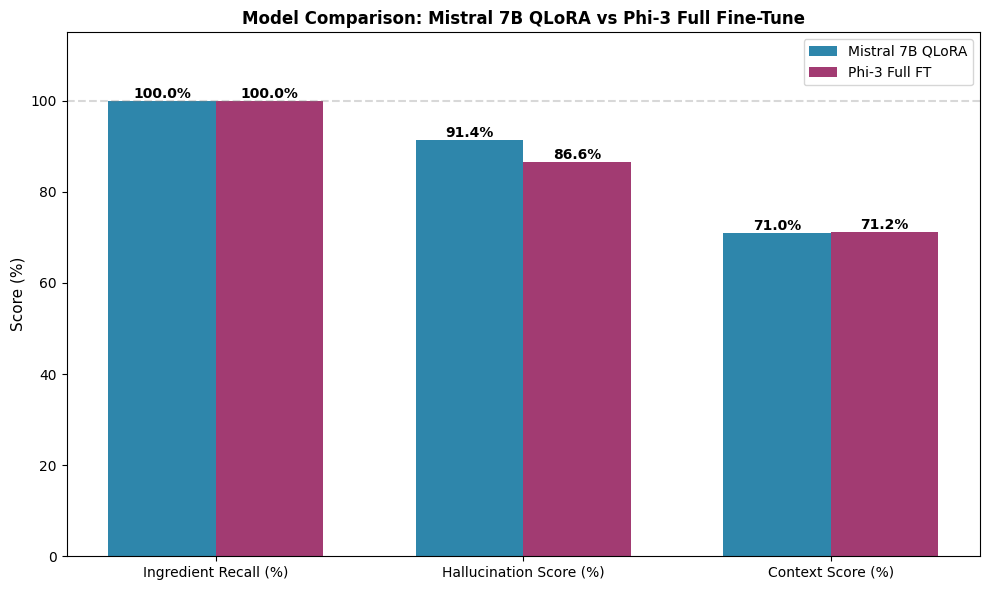

Figure saved: model_comparison.png


In [14]:
import matplotlib.pyplot as plt
import numpy as np

models = summary.index.tolist()
metrics = ["Ingredient Recall (%)", "Hallucination Score (%)", "Context Score (%)"]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2E86AB', '#A23B72']
for i, model in enumerate(models):
    values = [summary.loc[model, m] for m in metrics]
    bars = ax.bar(x + i*width, values, width, label=model, color=colors[i])

    for bar, val in zip(bars, values):
        ax.annotate(f'{val:.1f}%',
                    xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Score (%)', fontsize=11)
ax.set_title('Model Comparison: Mistral 7B QLoRA vs Phi-3 Full Fine-Tune', fontsize=12, fontweight='bold')
ax.set_xticks(x + width/2)
ax.set_xticklabels(metrics, fontsize=10)
ax.legend(fontsize=10)
ax.set_ylim(0, 115)
ax.axhline(y=100, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved: model_comparison.png")

### 5.4 Export Results

In [15]:
# Save evaluation results
summary.to_csv("evaluation_summary.csv")
df.to_csv("evaluation_detailed.csv", index=False)

with open("evaluation_full.json", "w") as f:
    json.dump({
        "summary": summary.to_dict(),
        "detailed": evaluations
    }, f, indent=2)

# Copy to Google Drive for backup
!cp mistral_results.json /content/drive/MyDrive/
!cp phi3_results.json /content/drive/MyDrive/
!cp evaluation_summary.csv /content/drive/MyDrive/
!cp evaluation_detailed.csv /content/drive/MyDrive/
!cp model_comparison.png /content/drive/MyDrive/

print("Results exported:")
print("  - evaluation_summary.csv")
print("  - evaluation_detailed.csv")
print("  - evaluation_full.json")
print("  - model_comparison.png")
print("\nAll files backed up to Google Drive.")

Results exported:
  - evaluation_summary.csv
  - evaluation_detailed.csv
  - evaluation_full.json
  - model_comparison.png

All files backed up to Google Drive.


## 6. Sample Output Comparison

This section allows inspection of individual model outputs for qualitative analysis.

In [16]:
def compare_outputs(scenario_id: int):
    """
    Display outputs from both models for a given scenario.

    Args:
        scenario_id: The test scenario ID (1-100)
    """
    scenario = TEST_SCENARIOS[scenario_id - 1]

    print("=" * 70)
    print(f"SCENARIO {scenario_id}: {scenario['context'].upper()}")
    print(f"Ingredients: {', '.join(scenario['ingredients'])}")
    print(f"Note: {scenario['note']}")
    print("=" * 70)

    for results, name in [(mistral_results, "MISTRAL 7B QLoRA"), (phi3_results, "PHI-3 FULL FT")]:
        entry = next((e for e in results if e["id"] == scenario_id), None)
        if entry:
            eval_row = next((e for e in evaluations if e["scenario_id"] == scenario_id and e["model"] == entry["model"]), None)

            print(f"\n--- {name} ---")
            print(f"Scores: Recall={eval_row['ingredient_recall']}% | Hallucination={eval_row['hallucination_score']}% | Context={eval_row['context_score']}%")

            if eval_row['hallucinated']:
                print(f"Hallucinated ingredients: {eval_row['hallucinated']}")
            if eval_row['missed_ingredients']:
                print(f"Missed ingredients: {eval_row['missed_ingredients']}")

            output_preview = entry['output_text'][:600]
            if len(entry['output_text']) > 600:
                output_preview += "..."
            print(f"\nOutput:\n{output_preview}")


# Example: Compare outputs for critical vegan test scenarios
print("SAMPLE COMPARISONS: CRITICAL HALLUCINATION TEST CASES")
print()

compare_outputs(2)   # Vegan breakfast: oats, banana, honey
print("\n")
compare_outputs(52)  # Vegan pasta: pasta, tomato, basil, garlic

SAMPLE COMPARISONS: CRITICAL HALLUCINATION TEST CASES

SCENARIO 2: BREAKFAST
Ingredients: oats, banana, honey
Note: Vegan - should not add milk

--- MISTRAL 7B QLoRA ---
Scores: Recall=100.0% | Hallucination=100% | Context=50.0%

Output:
We can make a simple honey-banana oat bowl.

Honey-Banana Oats:

Ingredients:
- Oats
- Banana, mashed
- Honey

Instructions:
1. Cook oats.
2. Mix in mashed banana.
3. Drizzle with honey and serve.

--- PHI-3 FULL FT ---
Scores: Recall=100.0% | Hallucination=100% | Context=100.0%

Output:
Here is a delicious recipe for you:

**Banana Oatmeal Pancakes**

Ingredients:
- oats
- banana
- honey

Instructions:
1. Blend oats to a fine consistency.
2. Mash banana and mix with oats.
3. Fold in honey to taste.
4. Cook spoonfuls in a non-stick pan.
5. Serve warm.


SCENARIO 52: DINNER
Ingredients: pasta, tomato, basil, garlic
Note: Vegan pasta - critical test

--- MISTRAL 7B QLoRA ---
Scores: Recall=100.0% | Hallucination=40% | Context=75.0%
Hallucinated ingredien